In [1]:
#Import all the required libraries
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import shutil, sys, os, glob, cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras
from keras import models
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

# hyperparameter optimization
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, Flatten

In [2]:
#Set random seed for the notebook for consistent results
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
#Code when running on google colab. Comment when running in local machine.
from google.colab import drive
drive.mount('/content/drive')

#to work with shared folders, add shortcut of folder to my drive 

#First zip the dataset folder and then using below command load/unzip dataset to Colab filesystem. 
#This approach is faster compared to reading from google drive
!unzip "/content/drive/MyDrive/Deep_Learning_Project_Group/Dataset-20210505T213130Z-001.zip" -d "/content"

Mounted at /content/drive
Archive:  /content/drive/MyDrive/Deep_Learning_Project_Group/Dataset-20210505T213130Z-001.zip
  inflating: /content/Dataset/with_mask/with_mask_1275.jpg  
  inflating: /content/Dataset/Testing Images/with_without_mask_1.jpg  
  inflating: /content/Dataset/with_mask/with_mask_1533.jpg  
  inflating: /content/Dataset/with_mask/with_mask_1691.jpg  
  inflating: /content/Dataset/with_mask/with_mask_971.jpg  
  inflating: /content/Dataset/with_mask/with_mask_1403.jpg  
  inflating: /content/Dataset/with_mask/with_mask_1158.jpg  
  inflating: /content/Dataset/with_mask/with_mask_1679.jpg  
  inflating: /content/Dataset/with_mask/with_mask_1903.jpg  
  inflating: /content/Dataset/with_mask/with_mask_1171.jpg  
  inflating: /content/Dataset/with_mask/with_mask_1864.jpg  
  inflating: /content/Dataset/with_mask/with_mask_1783.jpg  
  inflating: /content/Dataset/with_mask/with_mask_1744.jpg  
  inflating: /content/Dataset/with_mask/with_mask_1729.jpg  
  inflating: /con

In [4]:
#appending the pics to the training data list

In [5]:
#Now add the mask data from Colab filesystem to the list for data using open cv library, also add label column
#change path to location of files of images with mask when running using local images
#1 for mask and 0 for no mask
data = []
path='/content/Dataset/with_mask'
for img in os.listdir(path):
    pic = cv2.imread(os.path.join(path,img))
    pic = cv2.cvtColor(pic,cv2.COLOR_BGR2RGB)
    pic = cv2.resize(pic,(80,80))
    data.append([pic,1])#1 for masked data

In [6]:
#Now add the no mask data from Colab filesystem to the list for data using open cv library
#change path to location of files of images with no mask when running using local images
path='/content/Dataset/without_mask'
for img in os.listdir(path):
    pic = cv2.imread(os.path.join(path,img))
    pic = cv2.cvtColor(pic,cv2.COLOR_BGR2RGB)
    pic = cv2.resize(pic,(80,80))
    data.append([pic,0])#0 for without masked data

In [7]:
print("Total images in the Dataset",len(data))

Total images in the Dataset 4518


### Data Exploration

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


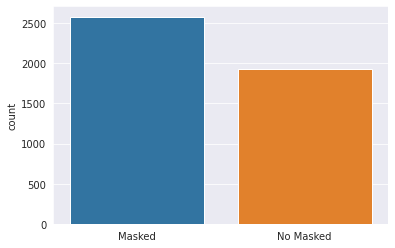

In [8]:
#Visualization to show distribution of labels in dataset
l = []
for i in data:
    if(i[1] == 0):
        l.append("No Masked")
    else:
        l.append("Masked")
sns.set_style('darkgrid')
sns.countplot(l)

In [9]:
## above visualization show we have fairly balanced dataset

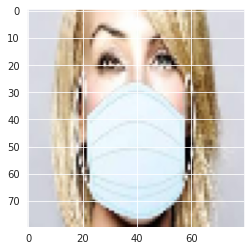

In [10]:
#Visualizations for few sample images in dataset
plt.imshow(np.array(data[1][0]).reshape(80,80,3))


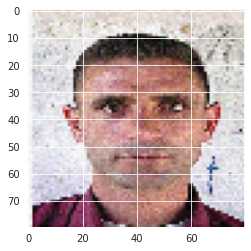

In [11]:
plt.imshow(np.array(data[-1][0]).reshape(80,80,3))

### Data Processing

In [12]:
#Reshape images and store in numpy arrays
X=[]
y=[]

for features,label in data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1,80,80,3)
Y= np.array(y)

In [13]:
#normalize the data
X= X/255.0

In [14]:
#splitting the data to train and test sets by 80-20 ratio
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.20, stratify=Y, random_state=42)

In [15]:
trainX.shape

(3614, 80, 80, 3)

In [16]:
testX.shape

(904, 80, 80, 3)

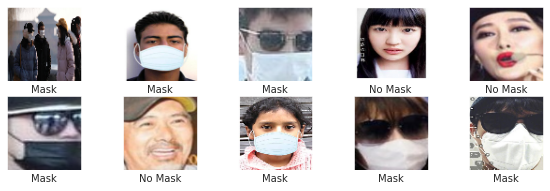

In [17]:
#Visualization of 10 images in the final training dataset
plt.figure(figsize=(10, 3))

for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(trainX[i], cmap=plt.cm.gray_r)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    if trainY[i]==0:
      label='No Mask' 
    else: 
      label='Mask'
    l1_plot.set_xlabel(label)

In [18]:
#data augumentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
        
#Fit training dataset to augmentor
datagen.fit(trainX)

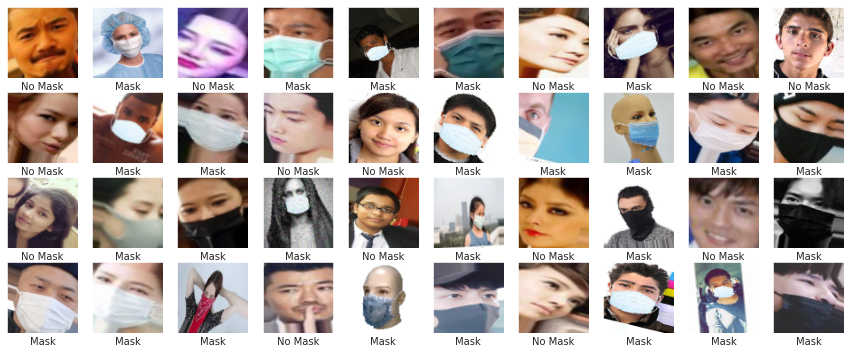

In [19]:
#Visualization after applying data augmentation
plt.figure(figsize=(15, 6))
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(trainX, trainY, batch_size=40):
	# create a grid of 10x2 images
  for i in range(0, 40):
    l1_plot = plt.subplot(4, 10, i + 1)
    l1_plot.imshow(X_batch[i], cmap=plt.get_cmap('gray'))
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    if y_batch[i]==0:
      label='No Mask' 
    else: 
      label='Mask'
    l1_plot.set_xlabel(label)
  # show the plot
  plt.show()
  break

# **Modeling**

In [20]:
#80-20 split of training data for train and validations
X_valid, X_train = trainX[:706], trainX[706:]
y_valid, y_train = trainY[:706], trainY[706:]

**Basic CNN for Mask detection**

Starting with the baseline model with 1 CNN layer

In [21]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# building a linear stack of layers with the sequential model
model = Sequential()
# convolutional layer with 32 kernels and keeping padding as same
model.add(Conv2D(32, 3,  padding='same', activation='relu', input_shape=(80,80,3)))
model.add(MaxPool2D())
# flatten output of conv for deep neural network following it
model.add(Flatten())
# hidden layer
model.add(Dense(100, activation='relu'))
# output layer, sigmoid function for binary classification problem
model.add(Dense(1, activation='sigmoid'))

opt = Adam(lr=0.000001)
model.compile(optimizer = opt ,loss= "binary_crossentropy",  metrics = ['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               5120100   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 5,121,097
Trainable params: 5,121,097
Non-trainable params: 0
_________________________________________________________________


In [23]:
#Early Stopping
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1,patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("best_model.h5",monitor='val_loss',verbose=1,save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb]

In [24]:
# training the model for 30 epochs
history=model.fit(X_train, y_train,  epochs=30, validation_data=(X_valid, y_valid),callbacks=callbacks) 

Epoch 1/30
91/91 [==============================] - 34s 13ms/step - loss: 0.6903 - accuracy: 0.5265 - val_loss: 0.6513 - val_accuracy: 0.6133

Epoch 00001: val_loss improved from inf to 0.65133, saving model to best_model.h5
Epoch 2/30
91/91 [==============================] - 1s 7ms/step - loss: 0.6409 - accuracy: 0.6436 - val_loss: 0.6183 - val_accuracy: 0.7550

Epoch 00002: val_loss improved from 0.65133 to 0.61832, saving model to best_model.h5
Epoch 3/30
91/91 [==============================] - 1s 7ms/step - loss: 0.6090 - accuracy: 0.7397 - val_loss: 0.5879 - val_accuracy: 0.7918

Epoch 00003: val_loss improved from 0.61832 to 0.58785, saving model to best_model.h5
Epoch 4/30
91/91 [==============================] - 1s 7ms/step - loss: 0.5783 - accuracy: 0.7941 - val_loss: 0.5596 - val_accuracy: 0.7819

Epoch 00004: val_loss improved from 0.58785 to 0.55958, saving model to best_model.h5
Epoch 5/30
91/91 [==============================] - 1s 7ms/step - loss: 0.5476 - accuracy: 0.7

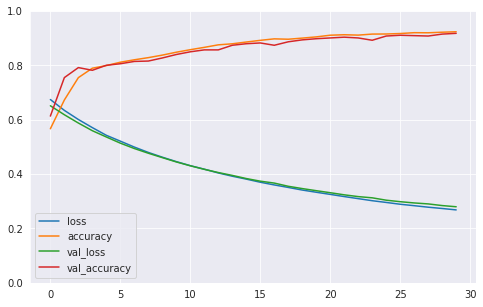

In [25]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

We can see that model does not converges. For 30 training epochs it keeps on saving best models with continuous decrease in loss.

In [26]:
#Evaluate model against unseen test data
saved_model = keras.models.load_model("best_model.h5")
print('Test Data :',saved_model.evaluate(testX,testY))

29/29 [==============================] - 0s 4ms/step - loss: 0.2809 - accuracy: 0.9181
Test Data : [0.2808871865272522, 0.9181416034698486]


In [27]:
pred=saved_model.predict_classes(testX)
#pred=(model.predict(testX) > 0.5).astype("int32")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [28]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(testY,pred))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90       387
           1       0.91      0.95      0.93       517

    accuracy                           0.92       904
   macro avg       0.92      0.91      0.92       904
weighted avg       0.92      0.92      0.92       904



In [29]:
#Confusion matrix for the model
confusion_matrix(testY,pred)

array([[339,  48],
       [ 26, 491]])

### Result Visualization

In [30]:
correct_data=[]
correct_datalabel=[]
missclass_data=[]
missclass_datalabel=[]
for i in range(len(testY)):
    if testY[i]==pred[i]:
        correct_data.append(testX[i])
        correct_datalabel.append(pred[i])
    else:
        missclass_data.append(testX[i])
        missclass_datalabel.append(pred[i])

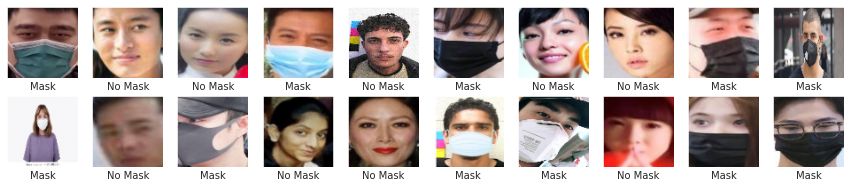

In [31]:
#Visualization of model output for correct prediction for test data
plt.figure(figsize=(15, 3))

for i in range(20):
    l1_plot = plt.subplot(2, 10, i + 1)
    l1_plot.imshow(correct_data[i], cmap=plt.cm.gray_r)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    if correct_datalabel[i]==0:
      label='No Mask' 
    else: 
      label='Mask'
    l1_plot.set_xlabel(label)

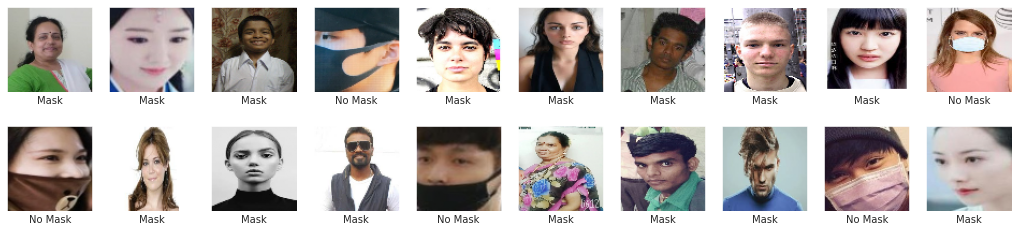

In [32]:
#Visualization of model output for wrong prediction for test data
plt.figure(figsize=(18, 4))

for i in range(20):
    l1_plot = plt.subplot(2, 10, i + 1)
    l1_plot.imshow(missclass_data[i], cmap=plt.cm.gray_r)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    if missclass_datalabel[i]==0:
      label='No Mask' 
    else: 
      label='Mask'
    l1_plot.set_xlabel(label)

In [33]:
img0=missclass_data[1]
img0=img0.reshape(1,80,80,3)

In [34]:
model.predict_classes(img0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[1]], dtype=int32)

Visualization of output for each CNN layer

Layers in model:
['conv2d', 'max_pooling2d', 'flatten', 'dense', 'dense_1']
Shape of first layer: (1, 80, 80, 32)


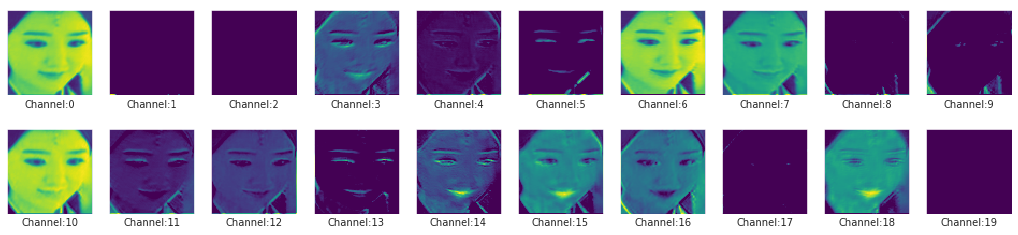

In [35]:
# Outputs of each layers, which include conv2D and max pooling layers
layer_outputs = [layer.output for layer in model.layers]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
activations = activation_model.predict(img0)
print("Layers in model:")
print([layer.name for layer in model.layers])
layer_names=[layer.name for layer in model.layers]
# Getting Activations of first layer i.e convolutional layer
first_layer_activation = activations[0]
  
# shape of first layer activation
print("Shape of first layer:",first_layer_activation.shape)
  
#for i in range(10):
 # plt.matshow(first_layer_activation[0, :, :, i], cmap ='viridis')

plt.figure(figsize=(18, 4))
plt.title(layer_names[0])
for i in range(20):
    l1_plot = plt.subplot(2, 10, i + 1)
    l1_plot.matshow(first_layer_activation[0, :, :, i], cmap ='viridis')
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel("Channel:"+str(i))

Visualization of intermediate layer output for correctly classified data

In [36]:
img1=correct_data[0]
img1=img1.reshape(1,80,80,3)

Layers in model:
['conv2d', 'max_pooling2d', 'flatten', 'dense', 'dense_1']
Shape of first layer: (1, 80, 80, 32)


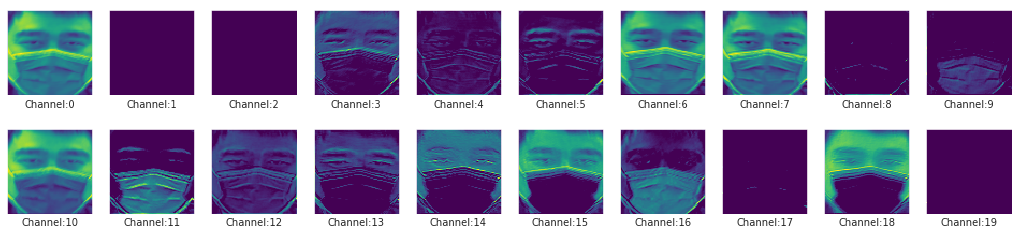

In [37]:
# Outputs of each layers, which include conv2D and max pooling layers
layer_outputs = [layer.output for layer in model.layers]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
activations = activation_model.predict(img1)
print("Layers in model:")
print([layer.name for layer in model.layers])
layer_names=[layer.name for layer in model.layers]
# Getting Activations of first layer i.e convolutional layer
first_layer_activation = activations[0]
  
# shape of first layer activation
print("Shape of first layer:",first_layer_activation.shape)
  
#for i in range(10):
 # plt.matshow(first_layer_activation[0, :, :, i], cmap ='viridis')

plt.figure(figsize=(18, 4))
plt.title(layer_names[0])
for i in range(20):
    l1_plot = plt.subplot(2, 10, i + 1)
    l1_plot.matshow(first_layer_activation[0, :, :, i], cmap ='viridis')
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel("Channel:"+str(i))

### HyperParameter Tuning

Modifying base CNN model before tuning

In [38]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

#Lets add more layers and pooling layers, etc to our base CNN model before tuning

model=Sequential()

#The first CNN layer

#Convolution layer of a kernel size 200
model.add(Conv2D(200,3, padding='same', activation='relu',input_shape=(80,80,3)))
#MaxPooling layer
model.add(MaxPool2D())

#The second convolution layer
#Convolution layer of a kernel size 100
model.add(Conv2D(100,(3,3)))
#Relu layer
model.add(Activation('relu'))
#MaxPooling layer
model.add(MaxPool2D())

#Flatten layer to stack the output convolutions from second convolution layer
model.add(Flatten())
#Performing Dropout to avoid overfitting
model.add(Dropout(0.5))
#Dense layer of 100 neurons
model.add(Dense(100,activation='relu'))

#The Final layer with two outputs for two categories and using softmax activation function 
model.add(Dense(2,activation='softmax'))

#Compiling the model, logit=True is required in loss function to avoid shape error for label column
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer='adam',metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 200)       5600      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 38, 38, 100)       180100    
_________________________________________________________________
activation (Activation)      (None, 38, 38, 100)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 19, 100)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36100)             0         
_________________________________________________________________
dropout (Dropout)            (None, 36100)             0

In [40]:
#Early Stopping and save best model to best_model_cnn.h5 file
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',verbose=0,patience=10)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("best_model_cnn.h5",monitor='val_loss',verbose=0,save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb]

In [41]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
# training the model for 30 epochs
history=model.fit(X_train, y_train,  epochs=30, validation_data=(X_valid, y_valid),callbacks=callbacks) 

Epoch 1/30
91/91 [==============================] - 4s 31ms/step - loss: 0.8341 - accuracy: 0.6303 - val_loss: 0.2767 - val_accuracy: 0.8994
Epoch 2/30
91/91 [==============================] - 2s 24ms/step - loss: 0.2354 - accuracy: 0.9235 - val_loss: 0.2295 - val_accuracy: 0.9193
Epoch 3/30
91/91 [==============================] - 2s 24ms/step - loss: 0.2310 - accuracy: 0.9186 - val_loss: 0.1564 - val_accuracy: 0.9363
Epoch 4/30
91/91 [==============================] - 2s 24ms/step - loss: 0.1489 - accuracy: 0.9518 - val_loss: 0.1569 - val_accuracy: 0.9348
Epoch 5/30
91/91 [==============================] - 2s 24ms/step - loss: 0.1462 - accuracy: 0.9476 - val_loss: 0.1389 - val_accuracy: 0.9448
Epoch 6/30
91/91 [==============================] - 2s 24ms/step - loss: 0.1094 - accuracy: 0.9597 - val_loss: 0.1641 - val_accuracy: 0.9391
Epoch 7/30
91/91 [==============================] - 2s 24ms/step - loss: 0.1469 - accuracy: 0.9486 - val_loss: 0.1647 - val_accuracy: 0.9292
Epoch 8/30
91

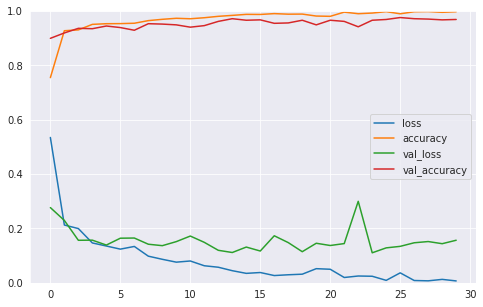

In [42]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [43]:
saved_model = keras.models.load_model("best_model_cnn.h5")
print('Test Data :',saved_model.evaluate(testX,testY))

29/29 [==============================] - 0s 11ms/step - loss: 0.1497 - accuracy: 0.9580
Test Data : [0.14965350925922394, 0.9579645991325378]


In [44]:
pred=saved_model.predict_classes(testX)
#pred=(model.predict(testX) > 0.5).astype("int32")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [45]:
print(classification_report(testY,pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       387
           1       0.97      0.96      0.96       517

    accuracy                           0.96       904
   macro avg       0.96      0.96      0.96       904
weighted avg       0.96      0.96      0.96       904



In [46]:
confusion_matrix(testY,pred)

array([[369,  18],
       [ 20, 497]])

In [47]:
# function to create the model for Keras wrapper to scikit learn for using grid search
# we will optimize the type of pooling layer (max or average) and the activation function of the 2nd and 3rd convolution layers , also the dropuout
def create_cnn_model(pool_type='max', conv_activation='sigmoid', dropout_rate=0.10):
    # create model
    model = Sequential()
    
    # first layer: convolution
    model.add(Conv2D(200,3, padding='same', activation='relu',input_shape=(80,80,3)))
        
    if pool_type == 'max':
        model.add(MaxPooling2D())
    if pool_type == 'average':
        model.add(AveragePooling2D())
    
    #The second convolution layer
    #Convolution layer of a kernel size 100
    model.add(Conv2D(100,(3,3),activation=conv_activation))
  
    if pool_type == 'max':
        model.add(MaxPooling2D())
    if pool_type == 'average':
        model.add(AveragePooling2D())

    model.add(Flatten())       
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate))  

    #Dense layer of 100 neurons
    model.add(Dense(100,activation=conv_activation))

    
    model.add(Dense(1, activation='sigmoid'))
    # output layer, sigmoid function for binary classification problem


    model.compile(optimizer = 'adam' ,loss= "binary_crossentropy",  metrics = ['accuracy'])
    
    #model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer='adam',metrics=['accuracy'])
    return model

cnn = create_cnn_model()


cnn.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 200)       5600      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 38, 38, 100)       180100    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 19, 100)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36100)             0         
_________________________________________________________________
dropout (Dropout)            (None, 36100)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               3

In [48]:
#Hyper Parameter Tuning
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# create model
model = KerasClassifier(build_fn=create_cnn_model)
# define parameters and values for grid search 
param_grid = {
    'pool_type': ['max', 'average'],
    'conv_activation': ['sigmoid', 'tanh','relu'],
    'dropout_rate': [0.1,0.2,0.5]
}

grid_searchcv = GridSearchCV(estimator=model, param_grid=param_grid, cv=3,verbose=1)
grid_searchcv.fit(X_train, y_train,validation_data=(X_valid, y_valid),epochs=30,
                  callbacks=[keras.callbacks.EarlyStopping()])



Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/30
61/61 [==============================] - 3s 34ms/step - loss: 2.1170 - accuracy: 0.5938 - val_loss: 1.4127 - val_accuracy: 0.5722
Epoch 2/30
61/61 [==============================] - 2s 26ms/step - loss: 1.1471 - accuracy: 0.5810 - val_loss: 0.7162 - val_accuracy: 0.5722
Epoch 3/30
61/61 [==============================] - 2s 26ms/step - loss: 0.6860 - accuracy: 0.5873 - val_loss: 0.6827 - val_accuracy: 0.5722
Epoch 4/30
31/31 [==============================] - 0s 11ms/step - loss: 0.6892 - accuracy: 0.5526
Epoch 1/30
61/61 [==============================] - 2s 34ms/step - loss: 2.5967 - accuracy: 0.4388 - val_loss: 1.6969 - val_accuracy: 0.4278
Epoch 2/30
61/61 [==============================] - 2s 26ms/step - loss: 1.3804 - accuracy: 0.4408 - val_loss: 0.8015 - val_accuracy: 0.4278
Epoch 3/30
61/61 [==============================] - 2s 26ms/step - loss: 0.7426 - accuracy: 0.4423 - val_loss: 0.6851 - val_accuracy: 0.5722
Epoch 4/30
61/61 [==============================] - 2s 

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  7.0min finished


91/91 [==============================] - 3s 26ms/step - loss: 0.8247 - accuracy: 0.5792 - val_loss: 0.3174 - val_accuracy: 0.8739
Epoch 2/30
91/91 [==============================] - 2s 25ms/step - loss: 0.2514 - accuracy: 0.9121 - val_loss: 0.2247 - val_accuracy: 0.9150
Epoch 3/30
91/91 [==============================] - 2s 25ms/step - loss: 0.2188 - accuracy: 0.9199 - val_loss: 0.1722 - val_accuracy: 0.9334
Epoch 4/30
91/91 [==============================] - 2s 25ms/step - loss: 0.1660 - accuracy: 0.9441 - val_loss: 0.1675 - val_accuracy: 0.9363
Epoch 5/30
91/91 [==============================] - 2s 25ms/step - loss: 0.1598 - accuracy: 0.9453 - val_loss: 0.1780 - val_accuracy: 0.9292


GridSearchCV(cv=3, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f12b49cad50>,
             iid='deprecated', n_jobs=None,
             param_grid={'conv_activation': ['sigmoid', 'tanh', 'relu'],
                         'dropout_rate': [0.1, 0.2, 0.5],
                         'pool_type': ['max', 'average']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [49]:
grid_searchcv.best_params_

{'conv_activation': 'relu', 'dropout_rate': 0.5, 'pool_type': 'max'}

In [50]:
model = grid_searchcv.best_estimator_.model
model.summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_108 (Conv2D)          (None, 80, 80, 200)       5600      
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 40, 40, 200)       0         
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 38, 38, 100)       180100    
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 19, 19, 100)       0         
_________________________________________________________________
flatten_54 (Flatten)         (None, 36100)             0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 36100)             0         
_________________________________________________________________
dense_108 (Dense)            (None, 100)             

In [51]:
model.evaluate(testX, testY)

29/29 [==============================] - 0s 8ms/step - loss: 0.1787 - accuracy: 0.9381


[0.17870494723320007, 0.9380530714988708]

Best model after parameter tuning gave 94% accuracy on test data, we used sigmoid function in final output layer as its binary classification problem.

**We changed the model to use softmax function in output layer, as it is just exansion of sigmoid for multi class problems. We found that performance of the model improved by 1. Hence below is our best basic CNN model for mask detection.**

In [52]:
saved_model = keras.models.load_model("best_model_cnn.h5")
print('Test Data :',saved_model.evaluate(testX,testY))

29/29 [==============================] - 0s 9ms/step - loss: 0.1497 - accuracy: 0.9580
Test Data : [0.14965350925922394, 0.9579645991325378]


In [53]:
pred=saved_model.predict_classes(testX)
#pred=(saved_model.predict(testX) > 0.5).astype("int32")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### Model Evaluation

In [54]:
print("Accuracy:", accuracy_score(testY,pred))
print("F1 Score:", f1_score(testY,pred))
print("Precision:", precision_score(testY,pred))
print("Recall:", recall_score(testY,pred))

Accuracy: 0.9579646017699115
F1 Score: 0.9631782945736433
Precision: 0.9650485436893204
Recall: 0.9613152804642167


In [55]:
from sklearn.metrics import roc_curve
y_pred_keras = pred.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(testY, y_pred_keras)

In [56]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

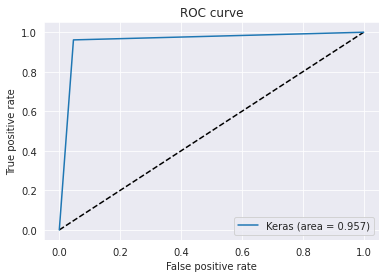

In [57]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

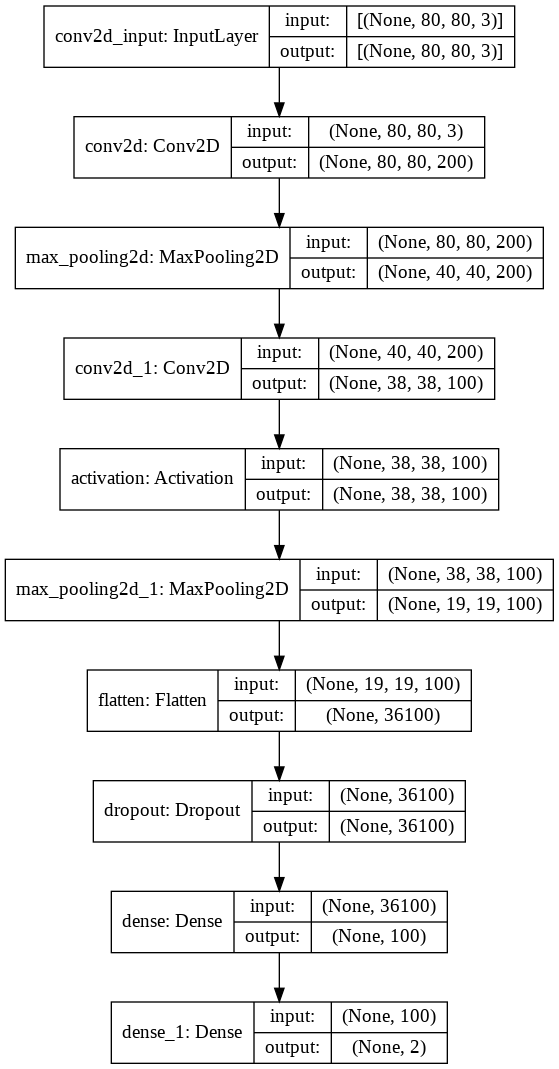

In [58]:
#Visualize final CNN architecture
from tensorflow.keras.utils import plot_model
plot_model(saved_model, to_file='cnn_model.png',show_shapes=True)

In [59]:
#Visualize results of intermediate layer result for one correctly classified data

In [60]:
correct_data=[]
correct_datalabel=[]
missclass_data=[]
missclass_datalabel=[]
for i in range(len(testY)):
    if testY[i]==pred[i]:
        correct_data.append(testX[i])
        correct_datalabel.append(pred[i])
    else:
        missclass_data.append(testX[i])
        missclass_datalabel.append(pred[i])

In [61]:
len(correct_data)

866

In [62]:
#Image with mask on and correctly predicted by model
img1=correct_data[0]
img1=img1.reshape(1,80,80,3)

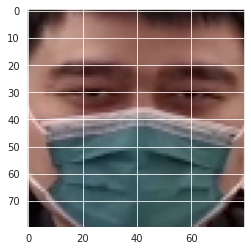

In [64]:
plt.imshow(img1.reshape(80,80,3))

Layers in model:
['conv2d', 'max_pooling2d', 'conv2d_1', 'activation', 'max_pooling2d_1', 'flatten', 'dropout', 'dense', 'dense_1']
Shape of first layer: (1, 80, 80, 200)


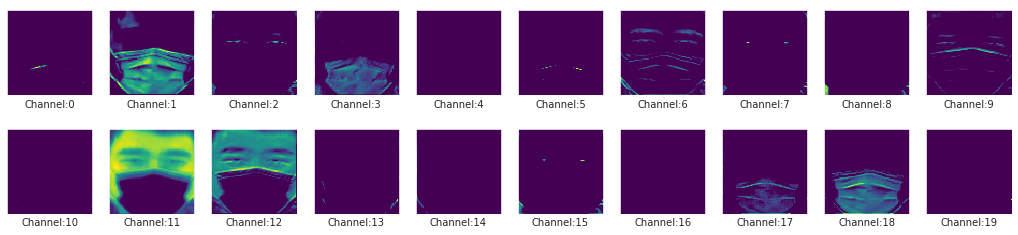

In [65]:
# Outputs of each layers, which include conv2D and max pooling layers
layer_outputs = [layer.output for layer in saved_model.layers]
activation_model = models.Model(inputs = saved_model.input, outputs = layer_outputs)
activations = activation_model.predict(img1)
print("Layers in model:")
print([layer.name for layer in saved_model.layers])
layer_names=[layer.name for layer in saved_model.layers]
# Getting Activations of first layer i.e convolutional layer
first_layer_activation = activations[0]
  
# shape of first layer activation
print("Shape of first layer:",first_layer_activation.shape)
  

plt.figure(figsize=(18, 4))
plt.title(layer_names[0])
for i in range(20):
    l1_plot = plt.subplot(2, 10, i + 1)
    l1_plot.matshow(first_layer_activation[0, :, :, i], cmap ='viridis')
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel("Channel:"+str(i))

max_pooling2d


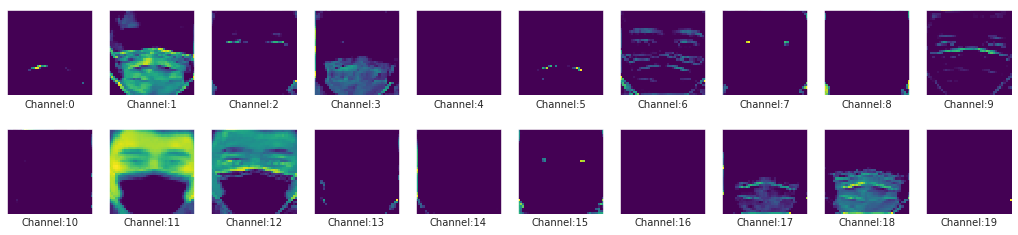

In [66]:
second_layer_activation = activations[1]
print(layer_names[1])
plt.figure(figsize=(18, 4))
plt.title(layer_names[1])
for i in range(20):
    l1_plot = plt.subplot(2, 10, i + 1)
    l1_plot.matshow(second_layer_activation[0, :, :, i], cmap ='viridis')
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel("Channel:"+str(i))

max_pooling2d_1


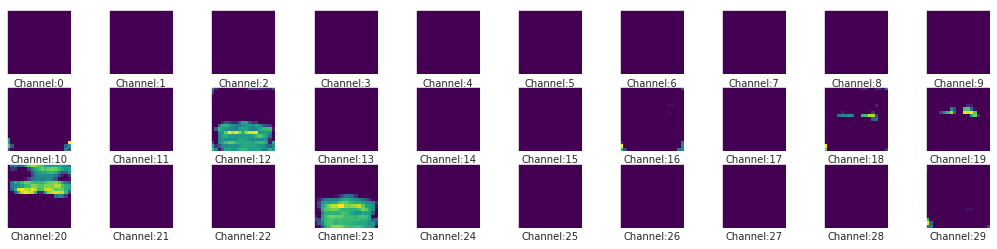

In [67]:
#Output after last layer of second convolution layer.
last_layer_activation = activations[4]
print(layer_names[4])
plt.figure(figsize=(18, 4))
plt.title(layer_names[4])
for i in range(30):
    l1_plot = plt.subplot(3, 10, i + 1)
    l1_plot.matshow(last_layer_activation[0, :, :, i], cmap ='viridis')
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel("Channel:"+str(i))

In [68]:
#Image with no mask on and correctly predicted by model
img1_n=correct_data[1]
img1_n=img1_n.reshape(1,80,80,3)

Layers in model:
['conv2d', 'max_pooling2d', 'conv2d_1', 'activation', 'max_pooling2d_1', 'flatten', 'dropout', 'dense', 'dense_1']
Shape of first layer: (1, 80, 80, 200)
conv2d


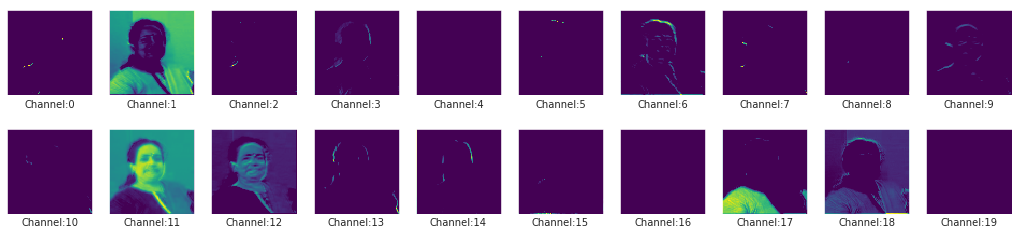

In [69]:
# Outputs of each layers, which include conv2D and max pooling layers
layer_outputs = [layer.output for layer in saved_model.layers]
activation_model = models.Model(inputs = saved_model.input, outputs = layer_outputs)
activations = activation_model.predict(img1_n)
print("Layers in model:")
print([layer.name for layer in saved_model.layers])
layer_names=[layer.name for layer in saved_model.layers]
# Getting Activations of first layer i.e convolutional layer
first_layer_activation = activations[0]
  
# shape of first layer activation
print("Shape of first layer:",first_layer_activation.shape)

print(layer_names[0])
plt.figure(figsize=(18, 4))
plt.title(layer_names[0])
for i in range(20):
    l1_plot = plt.subplot(2, 10, i + 1)
    l1_plot.matshow(first_layer_activation[0, :, :, i], cmap ='viridis')
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel("Channel:"+str(i))


max_pooling2d


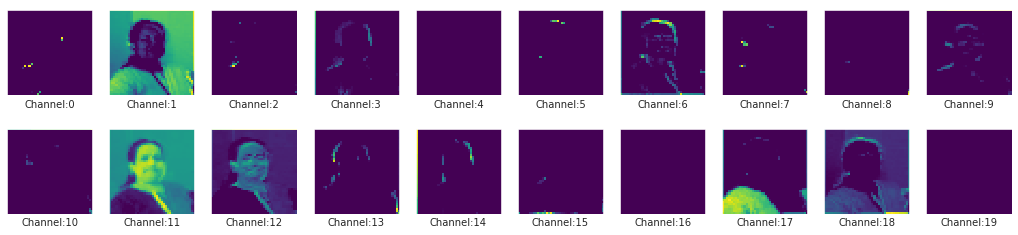

In [70]:
second_layer_activation = activations[1]
print(layer_names[1])
plt.figure(figsize=(18, 4))
plt.title(layer_names[1])
for i in range(20):
    l1_plot = plt.subplot(2, 10, i + 1)
    l1_plot.matshow(second_layer_activation[0, :, :, i], cmap ='viridis')
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel("Channel:"+str(i))

max_pooling2d_1


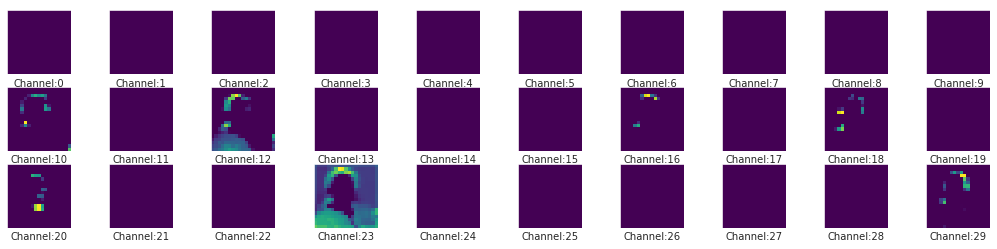

In [71]:
#Output after last layer of second convolution layer.
last_layer_activation = activations[4]
print(layer_names[4])
plt.figure(figsize=(18, 4))
plt.title(layer_names[4])
for i in range(30):
    l1_plot = plt.subplot(3, 10, i + 1)
    l1_plot.matshow(last_layer_activation[0, :, :, i], cmap ='viridis')
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel("Channel:"+str(i))

Output of each layers to show misclassified data

In [72]:
missclass_datalabel[:10]

[0, 0, 1, 1, 1, 0, 0, 0, 1, 1]

In [73]:
#Image with  mask on and  predicted  wrong by model
img0_miss=missclass_data[0]
img0_miss=img0_miss.reshape(1,80,80,3)

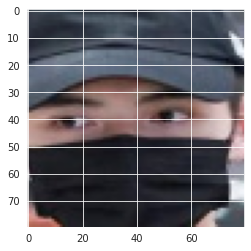

In [74]:
plt.imshow(img0_miss.reshape(80,80,3))

Layers in model:
['conv2d', 'max_pooling2d', 'conv2d_1', 'activation', 'max_pooling2d_1', 'flatten', 'dropout', 'dense', 'dense_1']
Shape of first layer: (1, 80, 80, 200)


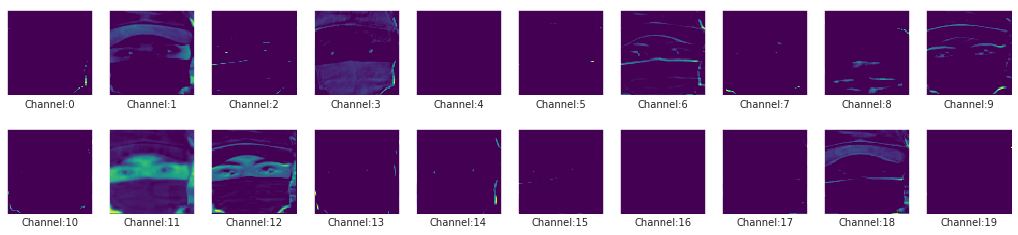

In [75]:
# Outputs of each layers, which include conv2D and max pooling layers
layer_outputs = [layer.output for layer in saved_model.layers]
activation_model = models.Model(inputs = saved_model.input, outputs = layer_outputs)
activations = activation_model.predict(img0_miss)
print("Layers in model:")
print([layer.name for layer in saved_model.layers])
layer_names=[layer.name for layer in saved_model.layers]
# Getting Activations of first layer i.e convolutional layer
first_layer_activation = activations[0]
  
# shape of first layer activation
print("Shape of first layer:",first_layer_activation.shape)
  

plt.figure(figsize=(18, 4))
plt.title(layer_names[0])
for i in range(20):
    l1_plot = plt.subplot(2, 10, i + 1)
    l1_plot.matshow(first_layer_activation[0, :, :, i], cmap ='viridis')
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel("Channel:"+str(i))

max_pooling2d_1


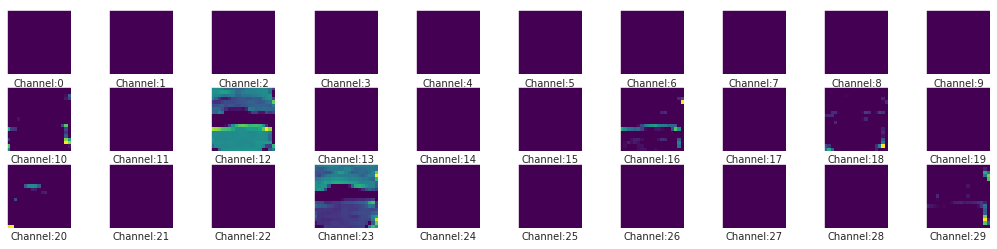

In [76]:
#Output after last layer of second convolution layer.
last_layer_activation = activations[4]
print(layer_names[4])
plt.figure(figsize=(18, 4))
plt.title(layer_names[4])
for i in range(30):
    l1_plot = plt.subplot(3, 10, i + 1)
    l1_plot.matshow(last_layer_activation[0, :, :, i], cmap ='viridis')
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel("Channel:"+str(i))

In [77]:
#Image with no mask on and  predicted  wrong by model
img1_miss=missclass_data[3]
img1_miss=img1_miss.reshape(1,80,80,3)

Layers in model:
['conv2d', 'max_pooling2d', 'conv2d_1', 'activation', 'max_pooling2d_1', 'flatten', 'dropout', 'dense', 'dense_1']
Shape of first layer: (1, 80, 80, 200)


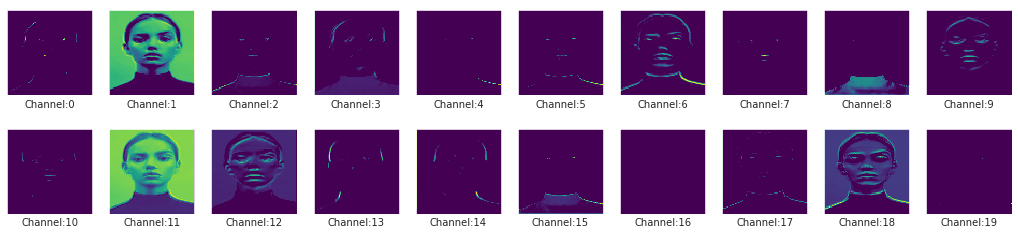

In [78]:
# Outputs of each layers, which include conv2D and max pooling layers
layer_outputs = [layer.output for layer in saved_model.layers]
activation_model = models.Model(inputs = saved_model.input, outputs = layer_outputs)
activations = activation_model.predict(img1_miss)
print("Layers in model:")
print([layer.name for layer in saved_model.layers])
layer_names=[layer.name for layer in saved_model.layers]
# Getting Activations of first layer i.e convolutional layer
first_layer_activation = activations[0]
  
# shape of first layer activation
print("Shape of first layer:",first_layer_activation.shape)
  

plt.figure(figsize=(18, 4))
plt.title(layer_names[0])
for i in range(20):
    l1_plot = plt.subplot(2, 10, i + 1)
    l1_plot.matshow(first_layer_activation[0, :, :, i], cmap ='viridis')
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel("Channel:"+str(i))

max_pooling2d_1


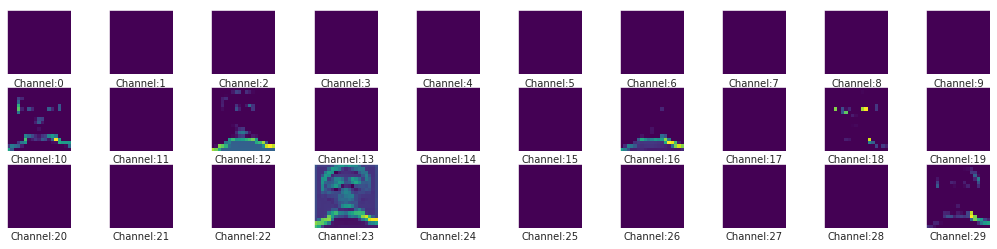

In [79]:
#Output after last layer of second convolution layer.
last_layer_activation = activations[4]
print(layer_names[4])
plt.figure(figsize=(18, 4))
plt.title(layer_names[4])
for i in range(30):
    l1_plot = plt.subplot(3, 10, i + 1)
    l1_plot.matshow(last_layer_activation[0, :, :, i], cmap ='viridis')
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel("Channel:"+str(i))